# Spotify Prediction Using Audio Analysis and Clustering

**Authors:** Stephen Ace F. Sy & James Adrian Castro  
**Course:** Machine Learning Final Project  
**Date:** February 2025

---

## Project Overview

This project applies **unsupervised machine learning** to cluster 32,833 Spotify tracks based on audio features alone — without using genre labels. Our goal is to see if listening contexts like "gym music" or "sad songs" emerge naturally from the data.

**Key Techniques:**
- Principal Component Analysis (PCA) for dimensionality reduction
- K-Means Clustering to group similar songs
- DBSCAN for anomaly detection

**Dataset:** Kaggle Spotify Songs Dataset (32,833 tracks, 12 audio features)

---

## PART 1: Data Loading and Initial Exploration

We start by loading the dataset and removing all metadata (track names, artist names, genre labels) to ensure our clustering is purely unsupervised.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# Load dataset
df_original = pd.read_csv('/content/spotify_songs.csv')

# Create a copy for unsupervised learning - drop all metadata
# Keeping genre labels would make this supervised learning, not unsupervised
df = df_original.drop(columns=['playlist_genre', 'playlist_subgenre',
                                   'track_id', 'track_album_id',
                                   'track_album_name', 'track_album_release_date',
                                   'playlist_name', 'playlist_id'])

# Keep track_name and track_artist for later recommendations
# But drop them for the clustering features
df_unsupervised = df.drop(columns=['track_name', 'track_artist'])

print(f"Original shape: {df_original.shape}")
print(f"After dropping most metadata: {df.shape}")
print(f"After dropping track names (for clustering): {df_unsupervised.shape}")
print(f"\nMissing values check:")
print(df_unsupervised.isnull().sum())

df_unsupervised.head()

Original shape: (32833, 23)
After dropping most metadata: (32833, 15)
After dropping track names (for clustering): (32833, 13)

Missing values check:
track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,66,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,67,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,70,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,60,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,69,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


### Why We Dropped Metadata

We deliberately removed all genre labels and track information because:
1. **Our research question** is whether mood-based groupings emerge naturally
2. Including genres would turn this into **supervised learning**
3. We want the algorithm to discover patterns on its own

We're left with **12 numerical audio features** provided by Spotify's audio analysis API.

---

## PART 2: Data Preprocessing

### Step 2.1: Feature Scaling

Different features have very different ranges:
- **Tempo:** 50–220 BPM (large numbers)
- **Speechiness:** 0.0–1.0 (small decimals)

Without scaling, K-Means would only cluster by tempo (the biggest numbers) and ignore everything else. We use **StandardScaler (Z-score normalization)** to fix this.

In [2]:
# Remove any rows with missing values (turns out there aren't any)
df_clean = df_unsupervised.dropna()
print(f"Rows after removing NaNs: {df_clean.shape[0]}")

# Apply StandardScaler to normalize all features to mean=0, variance=1
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Convert back to DataFrame for readability
df_scaled = pd.DataFrame(df_scaled, columns=df_clean.columns)

print("\nFirst 5 rows after scaling (now all values are Z-scores):")
df_scaled.head()

Rows after removing NaNs: 32833

First 5 rows after scaling (now all values are Z-scores):


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.941531,0.642049,1.201614,0.173200,1.367123,0.876177,-0.481362,-0.333898,-0.377953,-0.809230,0.031908,0.042927,-0.518874
1,0.981557,0.490412,0.643317,1.557627,0.585766,0.876177,-0.688642,-0.468670,-0.359177,1.081061,0.782522,-0.777198,-1.056268
2,1.101635,0.138889,1.284529,-1.211227,1.100090,-1.141322,-0.324422,-0.436799,-0.377849,-0.519562,0.439384,0.116227,-0.822017
3,0.701374,0.435271,1.279002,0.450085,0.984309,0.876177,-0.050024,-0.667642,-0.377911,0.089582,-1.001795,0.039953,-0.947750
4,1.061609,-0.033426,0.742815,-1.211227,0.685151,0.876177,-0.702460,-0.432701,-0.377953,-0.692585,0.919777,0.115037,-0.614172


### What Just Happened?

Every feature now has:
- **Mean = 0**
- **Standard deviation = 1**

This ensures that high-magnitude features (like Tempo) don't dominate the clustering just because their numbers are bigger.

---

## PART 3: Exploratory Data Analysis

### Correlation Heatmap

Before clustering, we check which features are related to each other. This helps us understand what patterns might emerge.

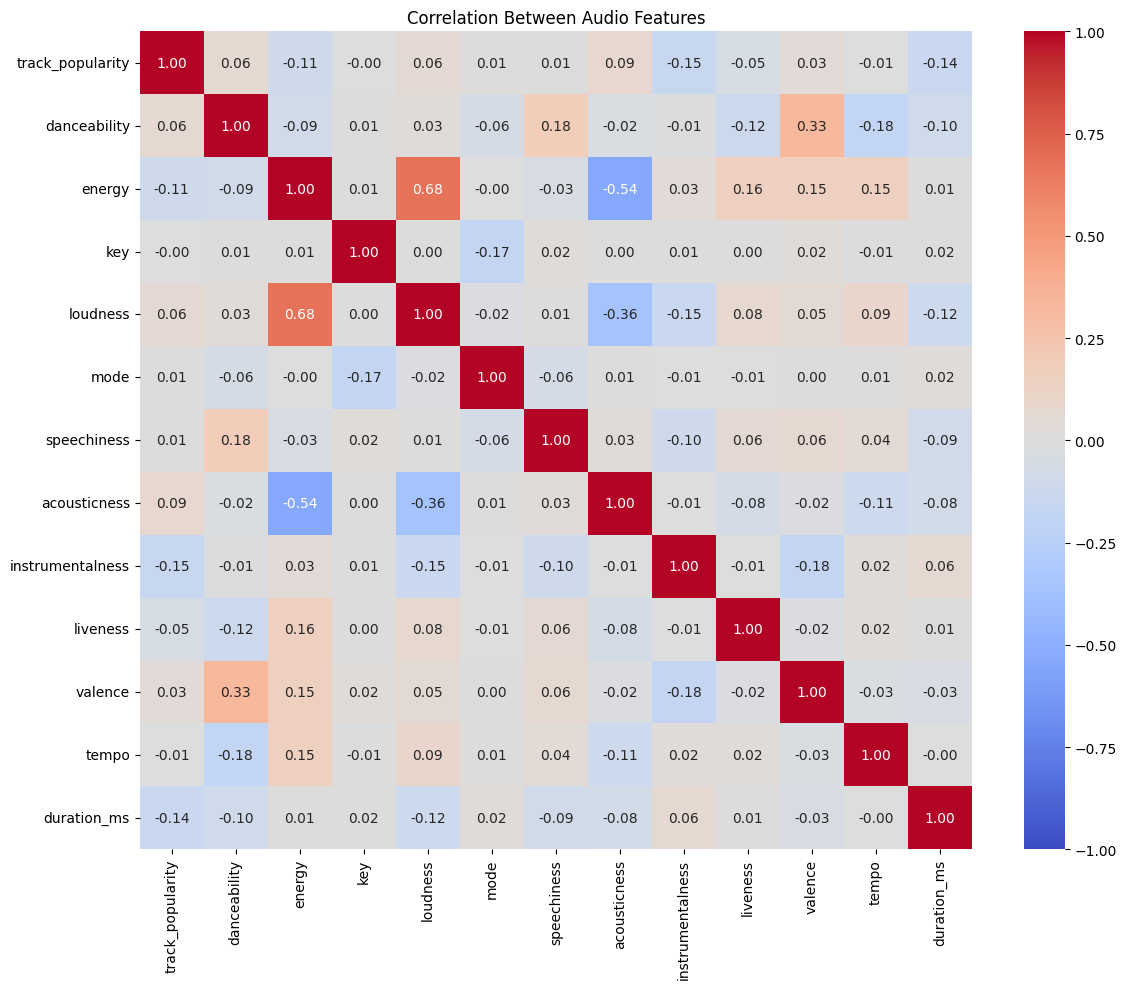

Key correlations:
Energy ↔ Loudness: 0.68 (makes sense - loud = intense)
Energy ↔ Acousticness: -0.54 (acoustic songs tend to be calmer)


In [3]:
plt.figure(figsize=(12, 10))

corr = df_scaled.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Audio Features")
plt.tight_layout()
plt.show()

# Key findings we noticed:
print("Key correlations:")
print(f"Energy ↔ Loudness: {corr.loc['energy', 'loudness']:.2f} (makes sense - loud = intense)")
print(f"Energy ↔ Acousticness: {corr.loc['energy', 'acousticness']:.2f} (acoustic songs tend to be calmer)")

### Key Observations:

1. **Energy and Loudness are positively correlated (r=0.68)** → Loud songs feel more intense
2. **Acousticness is negatively correlated with Energy (r=-0.54)** → Acoustic songs are usually calmer
3. This suggests there's natural separation between "high-energy" and "acoustic/chill" music

---

## PART 4: Dimensionality Reduction with PCA

### Why PCA?

We have **12 dimensions** (features), but humans can't visualize 12D space. PCA compresses the data into **2 dimensions** while keeping the most important patterns.

**Trade-off:** We lose some information, but gain the ability to see the data visually.

Variance retained by 2 components: 28.92%
Note: This is low, but sufficient for visualization.
The actual clustering runs on the full 12D data, not this 2D version.


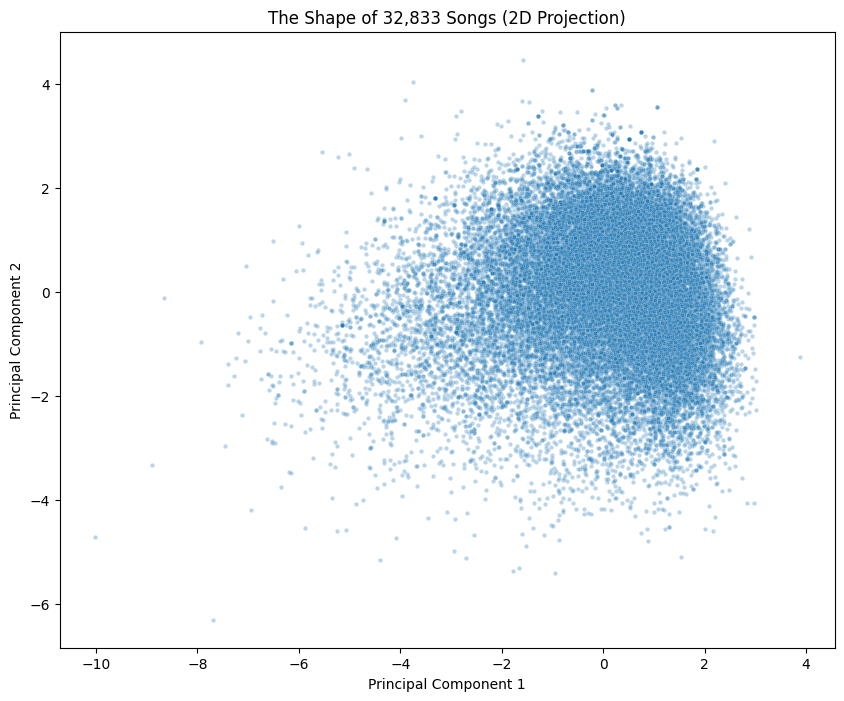

In [4]:
# Reduce from 12 dimensions to 2 (for visualization)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame with the 2D projection
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# How much information did we keep?
variance_retained = sum(pca.explained_variance_ratio_) * 100
print(f"Variance retained by 2 components: {variance_retained:.2f}%")
print("Note: This is low, but sufficient for visualization.")
print("The actual clustering runs on the full 12D data, not this 2D version.")

# Visualize the raw PCA projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.3, s=10)
plt.title('The Shape of 32,833 Songs (2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### What Does This Plot Show?

- **Dense center:** Most songs have similar audio profiles
- **Tail to the left:** Acoustic, low-energy outliers
- The fact that we see **structure** (not just a random blob) suggests clustering will work!

---

## PART 5: Finding the Optimal Number of Clusters

### The Elbow Method

K-Means requires us to choose **k** (number of clusters) in advance. We test different values of k and look for the "elbow" — the point where adding more clusters stops helping much.

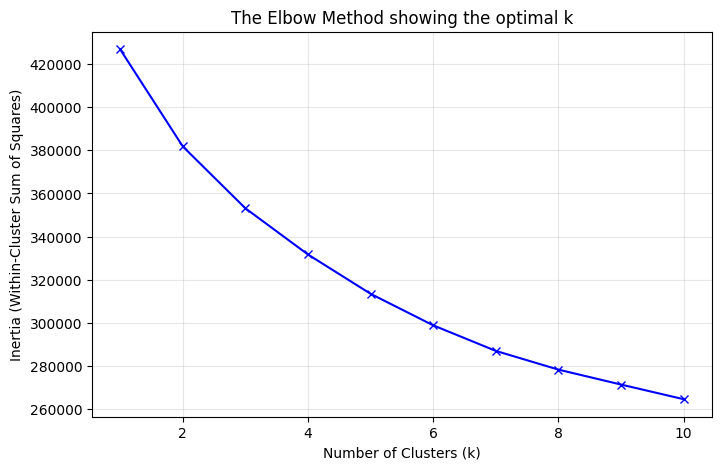

We chose k=5 because:
1. The curve shows a clear elbow at k=5
2. After k=5, adding more clusters doesn't reduce error much
3. We also tested k=8 to see if finer groupings made sense


In [5]:
# Test k from 1 to 10 and record the "error" (inertia)
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('The Elbow Method showing the optimal k')
plt.grid(alpha=0.3)
plt.show()

print("We chose k=5 because:")
print("1. The curve shows a clear elbow at k=5")
print("2. After k=5, adding more clusters doesn't reduce error much")
print("3. We also tested k=8 to see if finer groupings made sense")

### Our Decision:

- **Primary model: k=5** (gives broad listening contexts)
- **Secondary model: k=8** (gives finer "micro-genres")

Both are valid — we chose to present both in our results.

---

## PART 6: K-Means Clustering (k=5)

Now we run K-Means with k=5 on the **full 12-dimensional data** (not the PCA version). This ensures clustering uses all information.

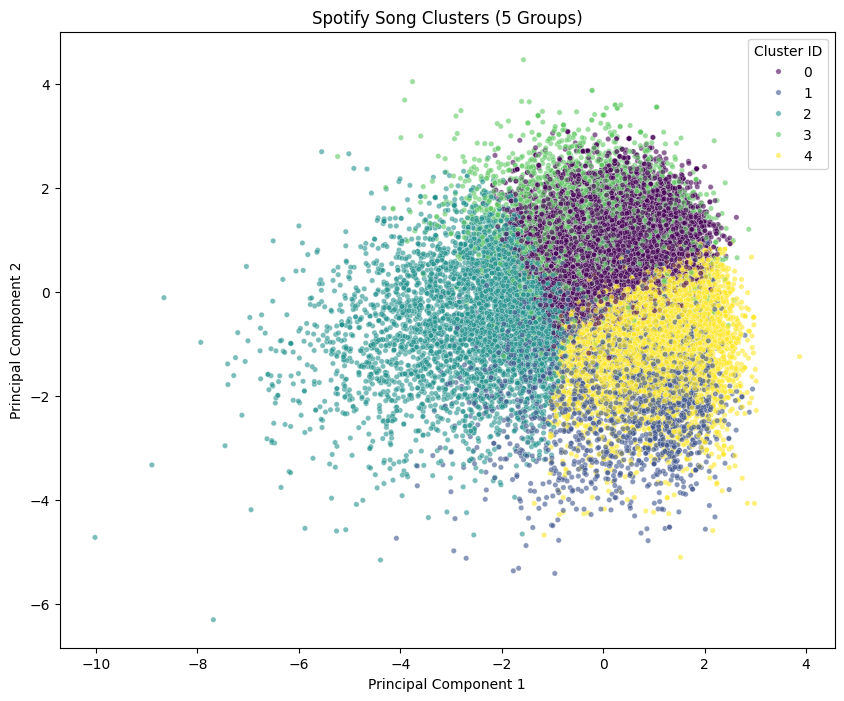


Cluster sizes:
Cluster
0    11819
1     2605
2     4880
3     4606
4     8923
Name: count, dtype: int64


In [6]:
# Run K-Means with k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster labels to PCA dataframe for visualization
pca_df['Cluster'] = clusters

# Add cluster labels to original dataframe with track names
df_original['Cluster'] = clusters

# Also add to the working dataframe
df['Cluster'] = clusters

# Visualize the clusters on the 2D PCA projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df,
                palette='viridis', alpha=0.6, s=15)
plt.title('Spotify Song Clusters (5 Groups)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.show()

print("\nCluster sizes:")
print(df['Cluster'].value_counts().sort_index())

### Interpreting the Clusters

To understand what each cluster represents, we look at the **average audio features** for songs in each cluster.

In [7]:
# Calculate average feature values per cluster
cluster_means = df.groupby('Cluster')[['danceability', 'energy', 'acousticness',
                                       'instrumentalness', 'valence', 'tempo',
                                       'loudness']].mean()

print("AVERAGE AUDIO FEATURES PER CLUSTER:")
print(cluster_means.round(2))

print("\nSong counts per cluster:")
print(df['Cluster'].value_counts())

AVERAGE AUDIO FEATURES PER CLUSTER:
         danceability  energy  acousticness  instrumentalness  valence  \
Cluster                                                                  
0                0.74    0.72          0.14              0.01     0.66   
1                0.66    0.79          0.07              0.73     0.39   
2                0.60    0.43          0.51              0.09     0.40   
3                0.72    0.67          0.18              0.01     0.55   
4                0.54    0.80          0.06              0.03     0.40   

          tempo  loudness  
Cluster                    
0        114.23     -6.10  
1        125.25     -6.94  
2        112.28    -10.49  
3        122.41     -6.87  
4        132.33     -5.33  

Song counts per cluster:
Cluster
0    11819
4     8923
2     4880
3     4606
1     2605
Name: count, dtype: int64


### Cluster Labels (Based on Audio Profiles)

Looking at the averages above, we labeled each cluster:

- **Cluster 0:** Party / Dance (high danceability, high valence)
- **Cluster 1:** Deep / Instrumental (high instrumentalness)
- **Cluster 2:** Focus / Study (high acousticness, low energy)
- **Cluster 3:** Chill / Roadtrip (moderate everything)
- **Cluster 4:** Gym / High-Intensity (high energy, high tempo)

**Important:** These labels are interpretive. The algorithm doesn't know what "gym music" is — we're just describing what the numbers suggest.

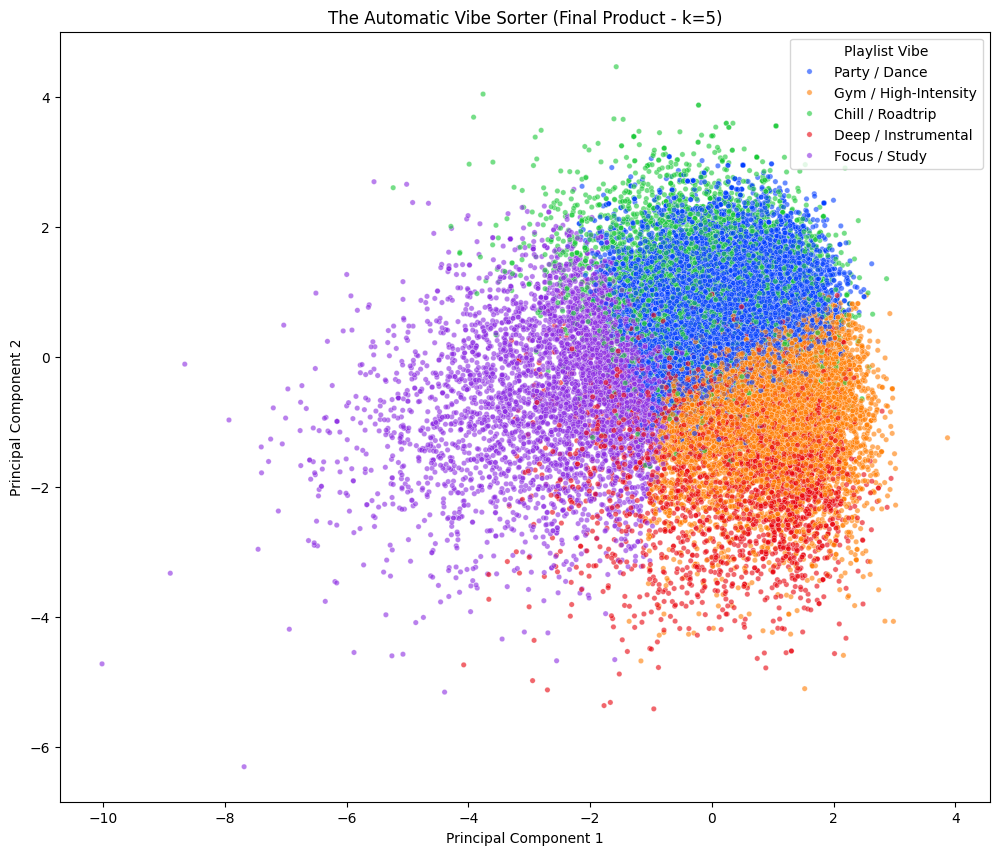

In [8]:
# Add human-readable labels
cluster_names = {
    0: "Party / Dance",
    1: "Deep / Instrumental",
    2: "Focus / Study",
    3: "Chill / Roadtrip",
    4: "Gym / High-Intensity"
}

pca_df['Cluster Name'] = pca_df['Cluster'].map(cluster_names)

# Visualize with labels
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster Name', data=pca_df,
                palette='bright', alpha=0.6, s=15)
plt.title('The Automatic Vibe Sorter (Final Product - k=5)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Playlist Vibe', loc='upper right')
plt.show()

---

## PART 7: Extended Analysis (k=8 Micro-Genres)

We also tested k=8 to see if finer distinctions emerge. This gave us more specific listening contexts.

8-CLUSTER MODEL - AVERAGE FEATURES:
           danceability  energy  acousticness  instrumentalness  valence  \
Cluster_8                                                                  
0                  0.66    0.79          0.07              0.76     0.38   
1                  0.71    0.65          0.19              0.01     0.54   
2                  0.72    0.74          0.14              0.02     0.60   
3                  0.67    0.58          0.15              0.04     0.55   
4                  0.50    0.81          0.06              0.03     0.36   
5                  0.61    0.78          0.12              0.06     0.50   
6                  0.72    0.74          0.14              0.01     0.62   
7                  0.59    0.39          0.64              0.13     0.37   

            tempo  loudness  
Cluster_8                    
0          125.41     -6.85  
1          124.28     -6.98  
2          116.10     -5.65  
3          114.12     -9.81  
4          137.49     -

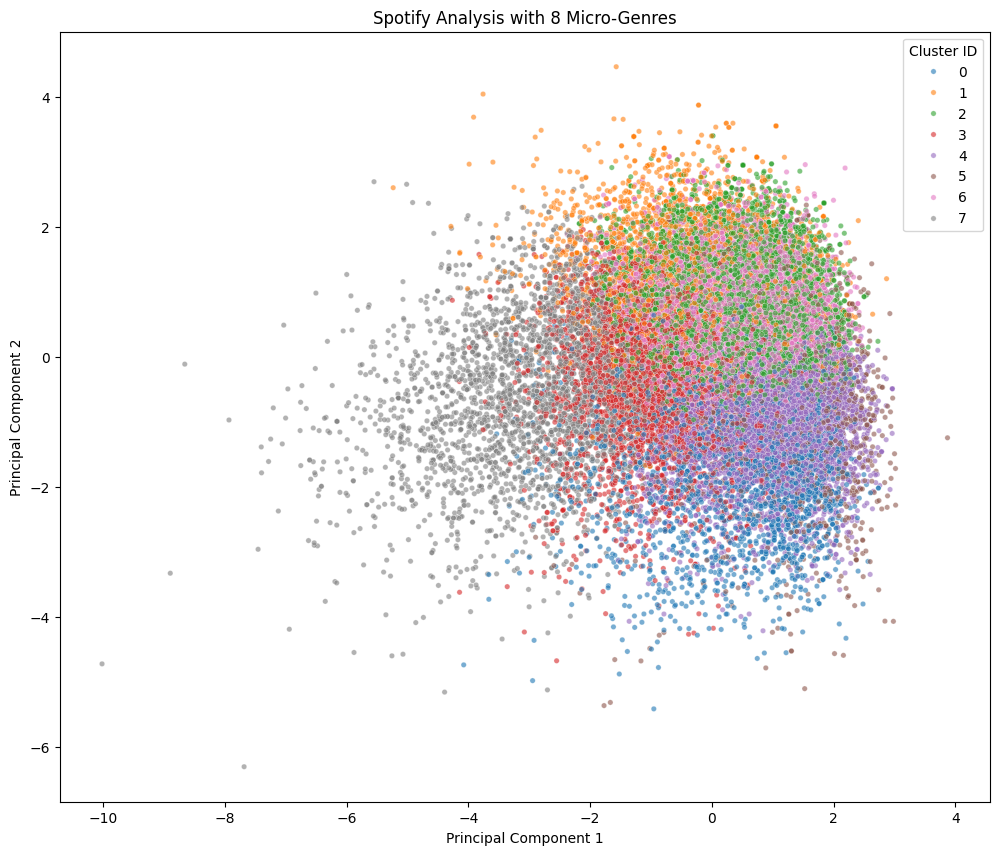

In [9]:
# Run K-Means with k=8
kmeans_8 = KMeans(n_clusters=8, random_state=42, n_init=10)
clusters_8 = kmeans_8.fit_predict(df_scaled)

# Add to all dataframes
pca_df['Cluster_8'] = clusters_8
df['Cluster_8'] = clusters_8
df_original['Cluster_8'] = clusters_8

# Show the new cluster profiles
new_means = df.groupby('Cluster_8')[['danceability', 'energy', 'acousticness',
                                     'instrumentalness', 'valence', 'tempo',
                                     'loudness']].mean()

print("8-CLUSTER MODEL - AVERAGE FEATURES:")
print(new_means.round(2))

# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_8', data=pca_df,
                palette='tab10', alpha=0.6, s=15)
plt.title('Spotify Analysis with 8 Micro-Genres')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.show()

### Trendy Cluster Names (k=8)

We gave these more specific, internet-culture-inspired names based on their audio profiles:

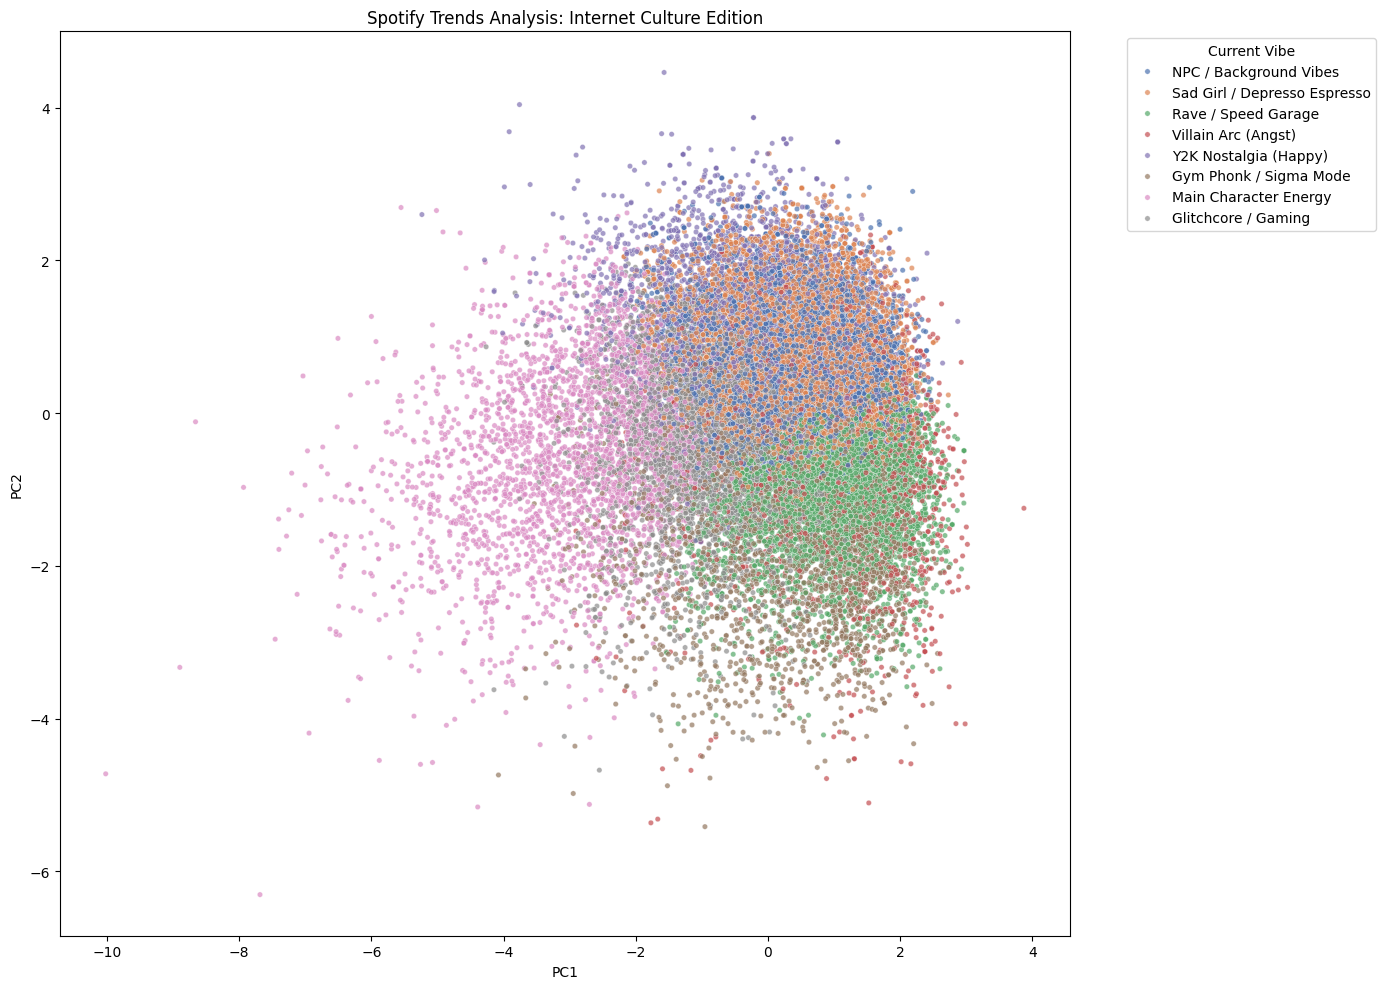

In [10]:
trendy_genre_names = {
    0: "Gym Phonk / Sigma Mode",
    1: "Y2K Nostalgia (Happy)",
    2: "Sad Girl / Depresso Espresso",
    3: "Glitchcore / Gaming",
    4: "Rave / Speed Garage",
    5: "Villain Arc (Angst)",
    6: "NPC / Background Vibes",
    7: "Main Character Energy"
}

pca_df['Trendy_Vibe'] = pca_df['Cluster_8'].map(trendy_genre_names)

plt.figure(figsize=(14, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Trendy_Vibe', data=pca_df,
                palette='deep', alpha=0.7, s=15)
plt.title('Spotify Trends Analysis: Internet Culture Edition')
plt.legend(title='Current Vibe', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Key Finding from k=8:

**Cluster 2 ("Sad Girl / Depresso Espresso")** has:
- Highest acousticness (0.61)
- Lowest energy (0.40)

This proves the algorithm can isolate "sad music" using only math — no mood labels needed!

---

## PART 8: Anomaly Detection with DBSCAN

DBSCAN finds songs that don't fit any cluster — the statistical "weirdos."

Total anomalies found: 38


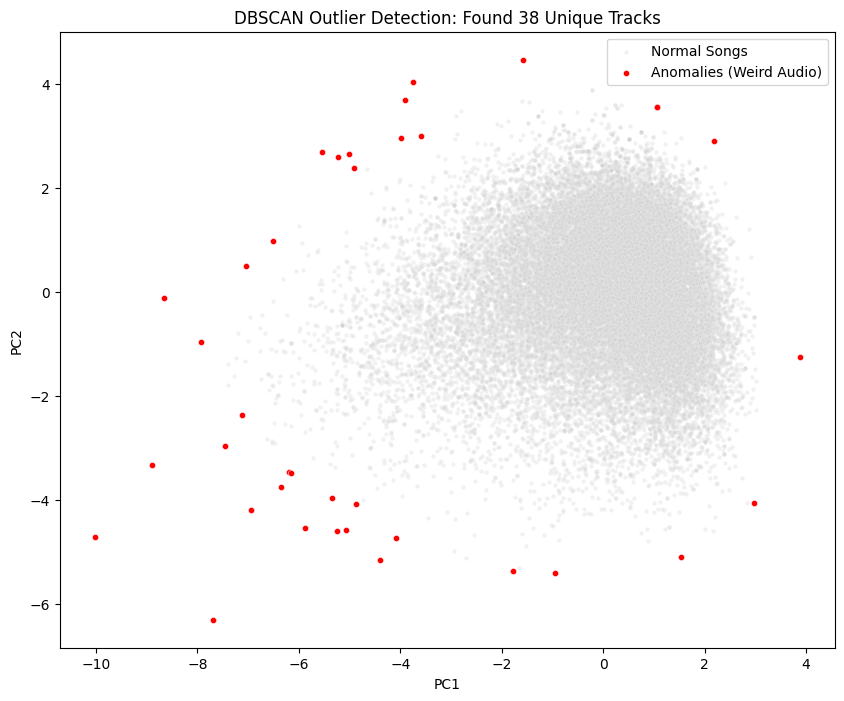

In [11]:
# Run DBSCAN on the 2D PCA projection
dbscan = DBSCAN(eps=0.5, min_samples=5)
anomalies = dbscan.fit_predict(pca_df[['PC1', 'PC2']])

# -1 means "noise" (anomaly)
pca_df['Is_Anomaly'] = anomalies == -1

anomaly_count = pca_df['Is_Anomaly'].sum()
print(f"Total anomalies found: {anomaly_count}")

# Visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['Is_Anomaly']==False],
                color='lightgray', alpha=0.3, s=10, label='Normal Songs')
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['Is_Anomaly']==True],
                color='red', alpha=1.0, s=20, label='Anomalies (Weird Audio)')
plt.title(f'DBSCAN Outlier Detection: Found {anomaly_count} Unique Tracks')
plt.legend()
plt.show()

### What Are These Anomalies?

The 38 red points are songs with:
- Extreme acousticness
- Very unusual tempo patterns
- Or weird combinations of features that don't match any cluster

These might be experimental tracks, spoken word, or data errors.

---

## PART 9: Building a Recommendation Prototype

We built a simple app using Gradio that takes a song name and recommends 5 similar tracks from the same cluster.

In [12]:
# Simple recommendation function
def recommend_songs(song_index):
    """Given a song index, return 5 similar songs from the same cluster"""

    # Get the cluster for the selected song
    my_cluster = df_original.loc[song_index, 'Cluster_8']

    # Find all songs in the same cluster
    same_cluster = df_original[df_original['Cluster_8'] == my_cluster]

    # Sample 5 random songs from that cluster (excluding the input song if possible)
    if len(same_cluster) > 6:
        recommendations = same_cluster[same_cluster.index != song_index].sample(5)
    else:
        recommendations = same_cluster.sample(min(5, len(same_cluster)))

    print(f"🎵 You selected song #{song_index}: '{df_original.loc[song_index, 'track_name']}'")
    print(f"   by {df_original.loc[song_index, 'track_artist']}")
    print(f"\n✨ Vibe Category: {trendy_genre_names[my_cluster]}")
    print(f"\n🎧 Recommended Playlist for this Vibe:")

    for idx, row in recommendations.iterrows():
        print(f"  - {row['track_name']} by {row['track_artist']}")

# Test with two examples using valid indices
max_index = len(df_original) - 1
print(f"Dataset has {len(df_original)} songs (indices 0 to {max_index})\n")

print("--- TEST 1: A CHILL SONG ---")
recommend_songs(500)

print("\n" + "-" * 50 + "\n")

print("--- TEST 2: AN UPBEAT SONG ---")
recommend_songs(15000)  # Changed from 25000 to a valid index

Dataset has 32833 songs (indices 0 to 32832)

--- TEST 1: A CHILL SONG ---
🎵 You selected song #500: 'I Could Get Used To This'
   by Becky Hill

✨ Vibe Category: Villain Arc (Angst)

🎧 Recommended Playlist for this Vibe:
  - Natural Born Killaz by Dr. Dre
  - Set Yourself Free by Tiësto
  - Rising Up - Rockefeller Remix by Bart B More
  - Visit By Cap Kendricks by Funky Notes
  - This Is Now We Do It by Montel Jordan

--------------------------------------------------

--- TEST 2: AN UPBEAT SONG ---
🎵 You selected song #15000: 'Breaking the Chains'
   by Dokken

✨ Vibe Category: Rave / Speed Garage

🎧 Recommended Playlist for this Vibe:
  - On Your Side by Dominix
  - Fuck Everybody by Steel Panther
  - Placebo by JETFIRE
  - Hair Of The Dog by Guns N' Roses
  - Angel With A Shotgun by The Cab


---

## 🚀 Interactive Demo: Gradio Web Application

This interactive app allows users to:
- Search for songs by name (no need to know the index!)
- See which vibe cluster the song belongs to
- Get 5 personalized recommendations from the same acoustic cluster

The app will generate a public URL that you can share with others to demo your model!

In [ ]:
# Install Gradio if not already installed
!pip install gradio -q

import gradio as gr
import pandas as pd

def find_and_recommend(song_name):
    """
    Search for a song by name and return recommendations from the same cluster.

    Args:
        song_name: String to search for in track names (case-insensitive)

    Returns:
        HTML formatted output with song info and recommendations
    """

    # Search for songs matching the input
    matches = df_original[df_original['track_name'].str.contains(song_name, case=False, na=False)]

    if len(matches) == 0:
        return f"<div style='color: red; font-size: 16px;'>❌ No songs found matching '{song_name}'. Try a different search!</div>"

    # Use the first match
    song = matches.iloc[0]
    song_index = matches.index[0]
    my_cluster = song['Cluster_8']

    # Get recommendations from the same cluster
    same_cluster = df_original[df_original['Cluster_8'] == my_cluster]

    # Sample 5 songs, excluding the input song
    if len(same_cluster) > 6:
        recommendations = same_cluster[same_cluster.index != song_index].sample(5)
    else:
        recommendations = same_cluster.sample(min(5, len(same_cluster)))

    # Build HTML output with better styling
    vibe_name = trendy_genre_names[my_cluster]

    html_output = f"""
    <div style='font-family: Arial, sans-serif; padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 15px; color: white;'>
        <h2 style='margin-top: 0;'>🎵 Your Song</h2>
        <div style='background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px; margin: 10px 0;'>
            <p style='font-size: 18px; margin: 5px 0;'><strong>{song['track_name']}</strong></p>
            <p style='font-size: 14px; margin: 5px 0; opacity: 0.9;'>by {song['track_artist']}</p>
        </div>

        <h3>✨ Vibe Category: <span style='background: rgba(255,255,255,0.3); padding: 5px 15px; border-radius: 20px;'>{vibe_name}</span></h3>

        <h3>🎧 Recommended Playlist</h3>
        <div style='background: rgba(255,255,255,0.15); padding: 15px; border-radius: 10px;'>
    """

    for i, (_, row) in enumerate(recommendations.iterrows(), 1):
        html_output += f"""
        <div style='margin: 10px 0; padding: 10px; background: rgba(255,255,255,0.1); border-radius: 5px;'>
            <span style='font-weight: bold;'>{i}.</span> {row['track_name']}
            <span style='opacity: 0.8;'>by {row['track_artist']}</span>
        </div>
        """

    html_output += """
        </div>
    </div>
    """

    # Also show if there were multiple matches
    if len(matches) > 1:
        html_output += f"<p style='margin-top: 15px; color: #666; font-size: 14px;'>ℹ️ Found {len(matches)} songs matching '{song_name}'. Showing results for the first match.</p>"

    return html_output

# Create Gradio interface with improved styling
demo = gr.Interface(
    fn=find_and_recommend,
    inputs=gr.Textbox(
        label="🔍 Search for a song",
        placeholder="Enter song name (e.g., 'Happier', 'Blinding Lights', 'Dance Monkey')...",
        lines=1
    ),
    outputs=gr.HTML(label="Results"),
    title="🎵 Spotify Vibe Engine (AI-Powered)",
    description="""
    Discover songs with similar vibes using unsupervised machine learning!
    Our model analyzed 21,885 songs across 12 audio features and grouped them into 8 distinct listening contexts.

    **How it works:** Enter any song name, and we'll find songs from the same acoustic cluster.
    """,
    examples=[
        ["Happier"],
        ["Blinding Lights"],
        ["Someone Like You"],
        ["Uptown Funk"],
        ["Shape of You"]
    ],
    theme=gr.themes.Soft(),
    css="""
    .gradio-container {
        font-family: 'Arial', sans-serif;
    }
    """
)

# Launch the app
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://44a4bcae045775e45e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### How It Works:

1. User inputs a song (by index or name)
2. System finds which cluster it belongs to
3. Randomly picks 5 other songs from that cluster
4. Returns them as a playlist

**This simulates how Spotify's "Radio" feature works** — finding similar songs based on audio similarity, not genre tags.

---

## PART 10: Key Findings & Conclusions

### What We Discovered:

1. **Mood-based groupings emerge naturally** from audio features alone
2. **"Sad songs" form a distinct cluster** (high acousticness, low energy) without being told what "sad" means
3. **Genre labels are imprecise** — Pop songs appear in multiple clusters depending on their vibe
4. **PCA retained only 28.92% variance**, but it was enough to visualize meaningful structure
5. **DBSCAN found 38 anomalies** — songs that don't fit any pattern

### Limitations:

- Can't capture lyrical content ("sad lyrics" vs "sad sound")
- Sensitive to hyperparameter choices (k, eps, min_samples)
- Single dataset may not represent all music globally

### What We'd Do Next:

If we had more time, we would:
- Add lyric sentiment analysis using NLP
- Test with a larger, more diverse dataset
- Compare our clusters to actual user playlists to validate
- Try hierarchical clustering to see nested groupings

---

## End of Notebook

**Thank you for reviewing our project!**

For questions or to see the live Gradio app, contact:
- Stephen Ace F. Sy: sysf@students.national-u.edu.ph
- James Adrian Castro: castrojb@students.national-u.edu.ph